# A simulation study of aperiodic fitting
### Given the power spectral density of a signal with a given power-law, possibly with some frequency peaks, how well the actual algorithm like FOOOF can recover the power-law exponent? What is the expected fluctuation over time of a signal (assumed stationary) reconstructed from a noisy such PSD? How does it depends on the frequency band of this PSD?

In [3]:
import matplotlib
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import scipy  as sp
import pandas as pd
# IO
import scipy.io as sio
import pickle
# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
# STFT
from scipy.signal import stft
from scipy import signal
from scipy.fft import fft, fftfreq, ifft
# Correlations
from scipy import stats
# Import the FOOOF object
from scipy.io import loadmat       # Import function to read data.
from pylab import *
import scipy.linalg as la   # SciPy Linear Algebra Library
from fooof import FOOOF
# Import the FOOOFGroup object
from fooof import FOOOFGroup
# Import a utility to download and load example data
from fooof.utils.download import load_fooof_data
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

# FUNCTIONS
## True PSD 

In [4]:
# Two types of noise to add to the spectrum: one depending on the frequency and another independent of it
def add_freq_WN(f,offset, pw_exp, knee, std, std_1overf):
    """Returns a function representing a power spectrum of type 'offset / (knee + f**pw_exp) + w_noise'.
    w_noise is distributed according to a normal distribution of mean 0 and std or std_1overf * offset/(knee+f**pw_exp).
    
    Arguments:
    f -- frequencies sample
    offset -- offset of the power law
    pw_exp -- power of the power law
    knee -- knee of the power law
    std -- std of the normal noise
    std_1overf -- std_1overf of the normal noise with power law type std
    
    """
    n_y = len(f)
    if std=='1/f':
        w_noise = np.random.normal(0, std_1overf * offset/(knee+f**pw_exp), n_y )
        y = offset / (knee + f**pw_exp) + w_noise
        for i in np.where(y < 0)[0]:
            while (y[i] < 0):
                y[i] = offset / (knee+f[i]**pw_exp) + np.random.normal(0, std_1overf * offset/(knee+f[i]**pw_exp) )
    else:
        w_noise = np.random.normal(0, std ,n_y)
        y = offset / (knee + f**pw_exp) + w_noise
        for i in np.where(y < 0)[0]:
            while (y[i] < 0):
                y[i] = offset / (knee+f[i]**pw_exp) + np.random.normal(0, std )
    return y

## Reconstruction of the signal from the PSD

In [5]:
def lfp_gen(offset, pw_exp, knee, std, std_1overf, fs, T):
    
    """Returns a timeseries with a PSD of type 'offset / (knee + f**pw_exp) + w_noise'.
    w_noise is distributed according to a normal distribution of mean 0 and std or std_1overf * offset/(knee+f**pw_exp).
    
    Arguments:
    fs -- sampling frequency
    T -- time length of the signal
    offset -- offset of the power law
    pw_exp -- power of the power law
    knee -- knee of the power law
    std -- std of the normal noise
    std_1overf -- std_1overf of the normal noise with power law type std
    
    """
    
    N      = int( fs * T )
    F      = arange(-fs/2,fs/2+fs/N,fs/N)
    Fp     = F[N//2+1:]
    
    PSDr   = add_freq_WN(Fp, offset, pw_exp, knee, std, std_1overf)
    PSDc   = append( append(PSDr[::-1] , offset/knee), PSDr )
    
    mag_spectrum = np.sqrt( PSDc * fs**2 * T)
    phase_spectrum = np.random.uniform(-np.pi,np.pi,len(F))
    spectrum = np.multiply(np.cos(phase_spectrum),mag_spectrum) + 1j*np.multiply(np.sin(phase_spectrum),mag_spectrum)

    ind_fft = arange(len(F))
    ind_fft = fftshift(ind_fft)
    sim_lfp = ifft(spectrum[ind_fft])
    
    return N, F, Fp, sim_lfp, PSDr

## Computation of Welch over time

In [6]:
def Welch_over_time(x_t, fs, nperseg, fracoverlap, nsegW, fracoverlapbig,details):
    """Returns the Welch over time of the timeseries x_t.

    Arguments:
    x_t -- timeseries
    fs -- sampling frequency of the time series
    nperseg -- length of each segment in Welch computation
    fracoverlap -- fraction of overlap between segments
    nsegW -- number of segments to form a big segment
    fracovelrapbig -- fraction of overlap between big segments
    
    """
    noverlap = nperseg * fracoverlap
    n_seg = nsegW * nperseg
    increment = int ( n_seg * (1. - fracoverlapbig) )
    n_times = len(x_t)
    
    if details==1:
        print('Sampling frequency is ' + str(fs) + 'Hz and thus maximal frequency (Nyquist frequency) is ' + str(fs/2) + 'Hz.')
        print('The time window size is ' + str(nperseg/fs) +
              's so the minimal frequency observed as well as the frequency step is thus ' + str(fs/nperseg) + 'Hz.')
        print('Time of a segment : ' + str(n_seg/fs) +'s')
        print('Time of a subsegment : ' + str(nperseg/fs) +'s')
        print('Time of an increment : ' + str(int((increment+1)/fs)) +'s')
    
    x_t_seg = x_t[0:n_seg]
    z_sig = x_t_seg
    #z_sig = (x_t_seg-mean(x_t_seg))/std(x_t_seg)
    f, Welch_time = signal.welch(z_sig, fs=fs, nperseg=nperseg, noverlap=noverlap)
    i = increment
    while i + n_seg < n_times:
        x_t_seg = x_t[i:i+n_seg]
        z_sig = x_t_seg
        #z_sig = (x_t_seg-mean(x_t_seg))/std(x_t_seg)
        f, welch_ = signal.welch(z_sig, fs=fs, nperseg=nperseg, noverlap=noverlap)
        Welch_time = np.c_[ Welch_time, welch_ ]
        i += increment  
    return f,Welch_time

## Computation of 1/f exponent and offset using different methods

In [7]:
def aperiodic_param(x_t, f_lo, f_hi):
    """Estimate the 1/f-exponent (power law exponent) of a timeseries with a PSD of type 'offset / f**pw_exp'.
    This exponent is extracted using the frequency band [f_lo, f_hi].
    
    Arguments:
    x_t -- timeseries
    f_lo -- frequency lower bound 
    f_hi -- frequency upper bound 
    
    """
    FOOOF_time = FOOOFGroup(peak_width_limits=[2, 8], min_peak_height=0.2, max_n_peaks = 4)
    freq_range = [f_lo, f_hi]
    f_W,Welch_time = Welch_over_time(x_t, fs, nperseg, fracoverlap, nsegW, fracoverlapbig,0)
    FOOOF_time.fit(f_W, Welch_time.T, freq_range)
    exp_time = FOOOF_time.get_params( 'aperiodic_params', 'exponent' )
    offset_time = FOOOF_time.get_params( 'aperiodic_params', 'offset' )
    #peak_time = FOOOF_time.get_params( 'peak_params' )
    
    return exp_time, offset_time
#peak_time

## Main function: compute 1/f-exponents for different lambda

In [8]:
def main_lambda(f_lo, f_hi, lambda_tab, n_sim, n_welch):
    """Estimate the 1/f-exponent (power law exponent) of timeseries generated from PSDs of type 
    'offset / f**pw_exp' with different power exponents.
    This exponent is extracted using the frequency band [f_lo, f_hi].
    
    Arguments:
    f_lo -- frequency lower bound 
    f_hi -- frequency upper bound
    lambda_tab -- power exponent list
    n_sim -- number of simulation
    n_welch -- list of different epochs on which the exponent is computed
    
    """
    
    n_lambda = len(lambda_tab)
    exp_tab = []
    offset_tab = []
    for lbda in range(0,n_lambda):
        pw_exp = lambda_tab[lbda]
        exp_ = zeros( (n_sim, n_welch) )
        offset_ = zeros( (n_sim, n_welch) )
        #peak_ = []
        for k in range(0,n_sim):
            N, F, Fp, sim_lfp, PSDr = lfp_gen(offset, pw_exp, knee, std, std_1overf, fs, T)
            real_sg  = real(sim_lfp)
            exp_time, offset_time = aperiodic_param(real_sg, 1, 45)
            exp_[k, :] = exp_time
            offset_[k, :] = offset_time
            
        exp_tab.append(exp_)
        offset_tab.append(offset_)
    
    return exp_tab, offset_tab

# PLOTS

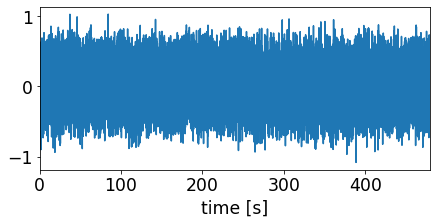

In [26]:
# In order to reconstruct a signal with this PSD,
# we need to complete it with its complex part by defining it in negative frequency.
# As a real signal, it is symmetric.
PSDc   = append( append(PSDr[::-1] , offset/knee), PSDr )
              
# From the PSD you get the FFT by taking square root of PSD(f) times exp(i phi(f)) where phi is the FFT phase
# Here phi is distributed following the uniform law on (-pi,pi)
# There is also the need of the scaling (fs^2 T)
mag_spectrum = np.sqrt( PSDc * fs**2 * T)
phase_spectrum = np.random.uniform(-np.pi,np.pi,len(PSDc))

spectrum = np.multiply(np.cos(phase_spectrum),mag_spectrum) + 1j*np.multiply(np.sin(phase_spectrum),mag_spectrum)

ind_fft = arange(len(F))
ind_fft = fftshift(ind_fft)
sim_lfp = ifft(spectrum[ind_fft])
figure(figsize = (7,3))
plot(arange(0,len(sim_lfp))/fs, real(sim_lfp))
xlabel('time [s]')
xlim((0,480))
show()

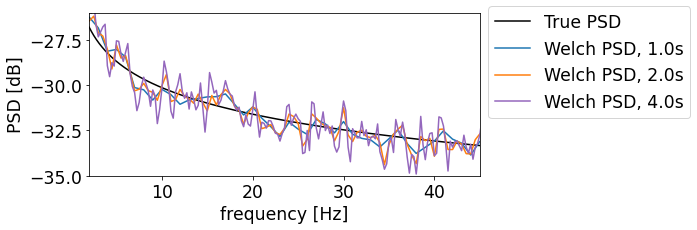

In [19]:
# Comparing the true PSD with Welch PSD
figure(figsize = (7,3))
pw_exp_tab = [0.5]
offset = 10**(-2.5)
knee   = 0.1
for i in range(0,len(pw_exp_tab)):
    pw_exp = pw_exp_tab[i]
    PSDr   = add_freq_WN(Fp, offset, pw_exp, knee, 0, 0)
    PSDc   = append( append(PSDr[::-1] , offset/knee), PSDr )
    mag_spectrum = np.sqrt( PSDc * fs**2 * T)
    phase_spectrum = np.random.uniform(-np.pi,np.pi,len(PSDc))
    spectrum = np.multiply(np.cos(phase_spectrum),mag_spectrum) + 1j*np.multiply(np.sin(phase_spectrum),mag_spectrum)
    ind_fft = arange(len(F))
    ind_fft = fftshift(ind_fft)
    sim_lfp = ifft(spectrum[ind_fft])
    
    plot(Fp, 10 * log10(PSDr), label = 'True PSD', color = 'black')
    fracoverlap = 0.5
    nperseg_tab = [200, 400, 800]
    nsegW_tab = [50, 25, 13]
    color_tab = ['C0','C1','C4']
    
    for k in range(0,len(nperseg_tab)):
        nperseg = nperseg_tab[k]
        nsegW = nsegW_tab[k]
        n_seg = nsegW * nperseg
        noverlap = nperseg * fracoverlap
        f, Pxx_den = signal.welch(real(sim_lfp[0:n_seg]), fs=fs, nperseg=nperseg, noverlap=noverlap)
        plot(f, 10 * log10(Pxx_den), label = 'Welch PSD, ' + str(nperseg / fs) + 's', color = color_tab[k])
xlabel('frequency [Hz]')
ylabel('PSD [dB]')
xlim((2,45))
ylim((-35,-26))
legend(bbox_to_anchor=(1, 0.3))
show()

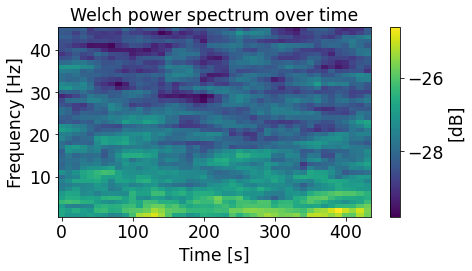

In [69]:
# Welch PSD estimation from the reconstructed signal
plt.figure(figsize=(7,3.5))
fs = 200                            # Sampling frequency of the time series
nperseg = 200                       # Length of each segment
fracoverlap = 0.5
nsegW = 50
fracoverlapbig = 0.8
noverlap = nperseg * fracoverlap    # Number of points to overlap between segments
n_times = len(real(sim_lfp))
n_seg = nsegW * nperseg
increment = int ( n_seg * (1 - fracoverlapbig) )
time_welch = arange(0,n_times - n_seg + increment,increment) / fs

f,Welch_time = Welch_over_time(real(sim_lfp), fs, nperseg, fracoverlap, nsegW, fracoverlapbig,0)

f_lo = 1
f_hi = 45
f_mask = (f >= f_lo) & (f <= f_hi)
pcolormesh(time_welch[0:len(time_welch)-1],f[f_mask],10 * log10(Welch_time[f_mask,:]))
colorbar(label='[dB]')                # ... with a color bar,
xlabel('Time [s]')        # ... and label the axes
ylabel('Frequency [Hz]')
title('Welch power spectrum over time')
show()

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.


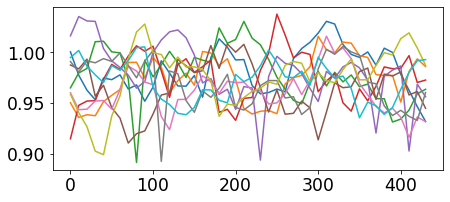

In [24]:
fs = 200                            # Sampling frequency of the time series
T  = 480
fracoverlap = 0.5
nsegW = 50
fracoverlapbig = 0.8
nperseg = 200
n_seg = nsegW * nperseg
increment = int ( n_seg * (1. - fracoverlapbig) )
n_welch = int( floor( ( fs*T - n_seg ) / increment ) ) + 1
lambda_tab =[1]
offset=10**(-2.5)
std = 0
std_1overf = 0.1
knee=0.1
n_sim = 10
f_lo=1
f_hi=45
exp_tab, offset_tab = main_lambda(f_lo, f_hi, lambda_tab, n_sim, n_welch)
figure(figsize=(7,3))
for k in range(n_sim):
    plot(10*arange(44),transpose(exp_tab[0][k,:]))
show()

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 power spectra.
Running FOOOFGroup across 44 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 pow

Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 43 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 pow

Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 41 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 pow

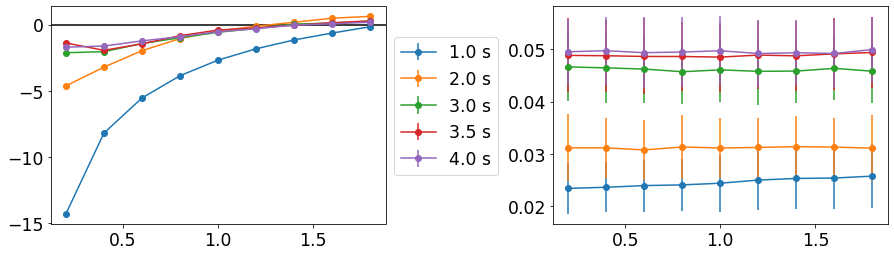

In [73]:
fs = 200                            # Sampling frequency of the time series
T  = 480

offset = 10**(-2.5)
knee   = 0.1
std = 0
std_1overf = 0

f_lo = 1
f_hi = 45
lambda_tab = arange(0.2,2.,0.2)
#lambda_tab = [ 0.2, 1., 2., 4.]
n_sim = 500
nperseg_tab = [200, 400, 600, 700, 800]
nsegW_tab = [50, 25, 17, 15, 13]
fracoverlap = 0.5
fracoverlapbig = 0.8

fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (15,4)
)
plt.subplots_adjust( wspace = 0.5 )
axes = axes.ravel()

for k in range(0,len(nperseg_tab)):
    nperseg = nperseg_tab[k]
    nsegW = nsegW_tab[k]
    n_seg = nsegW * nperseg
    increment = int ( n_seg * (1. - fracoverlapbig) )
    n_welch = int( floor( ( fs*T - n_seg ) / increment ) ) + 1
    exp_tab, offset_tab = main_lambda(f_lo, f_hi, lambda_tab, n_sim, n_welch)
    # data
    x = lambda_tab
    n_lambda = len(lambda_tab)
    mean_exp = [ exp_tab[k].mean(axis=1) for k in range(0,n_lambda) ]
    mean_exp = array(mean_exp)
    std_exp = [ exp_tab[k].std(axis=1) for k in range(0,n_lambda) ]
    std_exp = array(std_exp)
    y = mean_exp.mean(axis=1)
    y_std = std_exp.mean(axis=1)
    # std
    error = mean_exp.std(axis=1)
    error_std = std_exp.std(axis=1)
    axes[0].errorbar(x, (y-x)/x * 100, yerr=error, fmt='-o', label = str(nperseg/200) + ' s')
    axes[1].errorbar(x, y_std, yerr=error_std, fmt='-o', label = str(nperseg/200) + ' s')
    axes[0].legend(bbox_to_anchor=(1, 0.9))
axes[0].axhline(y=0, color='black')
savefig('figures/simulation/lambda_tab_same_window'+str(f_lo)+'Hz.pdf',bbox_inches='tight', format='pdf')
save('lambda_tab_same_window'+str(f_lo)+'Hz',[nperseg_tab,nsegW_tab, n_sim])